In [4]:
import numpy as np
import pandas as pd
import unittest
import matplotlib.pyplot as plt
import ipywidgets as widgets

C:\Users\yehor\AppData\Local\Temp\ipykernel_39048\3514916026.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [5]:
class Integral:
    def __init__(self, a, b, e):
        self.a = a
        self.b = b
        self.e = e
        
    @property
    def a(self):
        return self._a
    
    @a.setter
    def a(self, a):
        self._a = a
        
    @property
    def b(self):
        return self._b
    
    @b.setter
    def b(self, b):
        if b < self.a:
            raise ValueError('b must be greater than a')
        self._b = b
    
    @property
    def e(self):
        return self._e
    
    @e.setter
    def e(self, e):
        if e < 0:
            raise ValueError('e must be greater than 0')
        self._e = e
       
    def rectangle_integral(self, f, steps=1000):
        res1 = sum([f(i) for i in np.linspace(self.a, self.b, steps)]) * self.b / steps
        steps *= 2
        res2 = sum([f(i) for i in np.linspace(self.a, self.b, steps)]) * self.b / steps
        
        while abs(res1 - res2) > self.e:
            res1 = res2
            steps *= 2
            res2 = sum([f(i) for i in np.linspace(self.a, self.b, steps)]) * self.b / steps
        
        return round(res2, int(np.log10(1/self.e)))

In [6]:
#O -> sigma, B -> beta
class Lagger:
    def __init__(self, B, O):
        self.B = B
        self.O = O
    
    @property
    def B(self):
        return self._B
    
    @B.setter
    def B(self, B):
        if B < 0:
            raise ValueError('B must be greater than 0')
        self._B = B
        
    @property
    def O(self):
        return self._O
    
    @O.setter
    def O(self, O):
        if O < self.B:
            raise ValueError('O must be greater than B')
        self._O = O
        
    #Task 1 calulate_lagger -> lagger_function
    def calulate_lagger(self, t, n):
        lpprev=np.sqrt(self.O)*np.exp(-self.B*t/2)
        lp=np.sqrt(self.O)*(1-self.O*t)*np.exp(-self.B*t/2)
    
        if n==0:
            return lpprev
        if n==1:
            return lp
    
        for i in range(2, int(n+1)):
            temp=lp
            lp=(2*i-1-self.O*t)*lp/i-(i-1)*lpprev/i
            lpprev=temp
    
        return lp
    
    #Task 2
    def tabulate_lagger(self, T, n, num_points=200):
        points=np.linspace(0, T, num_points)
        results=self.calulate_lagger(points,n)
        ns=[n]*num_points;
        df=pd.DataFrame({'t': points, 'n' : ns, 'lagger': results})
        return df
    
    #Task 4
    def lagger_transformation_coefficients(self, f, T, N):
        ns = np.linspace(0, N, N+1)
        results = []
        for i in ns:
            def fun(f,i):
                return lambda x: f(x)*self.calulate_lagger(x, i)*np.exp(-(self.O-self.B)*x)
            results.append(Integral(0,T,0.0001).rectangle_integral(fun(f,i)))
        df = pd.DataFrame({'N' : ns, 'f' : results})
        return df
    
    #Task 6
    def lagger_inverse_transformation(self, H, t, k):
        res = 0
        for i in range(k+1):
            res += (H[i]*self.calulate_lagger(t,i))
        return res

In [7]:
#Task 3
class Experiment:
    def __init__(self, lagger):
        self.lagger = lagger
        
    @property
    def lagger(self):
        return self._lagger
    
    @lagger.setter
    def lagger(self, lagger):
        if not isinstance(lagger, Lagger):
            raise ValueError('lagger must be an instance of Lagger')
        self._lagger = lagger
        
    def experiment(self, T, N=20, eps=0.001):
        t = np.linspace(0, T, 1000)
        for i in t:
            for n in np.linspace(0, N, N+1):
                if abs(self.lagger.calulate_lagger(i,n))<eps:
                    flag = True
                else:
                    flag = False
                    break
            if flag:
                iss=[i]*(N+1)
                laggers = []
                ns = []
                for n in np.linspace(0, N, N+1):
                    laggers.append(self.lagger.calulate_lagger(i,n))
                    ns.append(n)
                df = pd.DataFrame({'t' : iss, 'n' : ns, 'lagger' : laggers})
                return df, i
                break

In [8]:
#Task 5
def f(x):
    if x>=2*np.pi:
        return 0
    else:
        return np.sin(x-np.pi/2)+1

In [9]:
lagger = Lagger(2, 4)
exp = Experiment(lagger)
df, ans = exp.experiment(100)
lagger.lagger_transformation_coefficients(f, ans, 20)

,N,f
0,0.0,0.0666
1,1.0,-0.1821
2,2.0,0.1780
3,3.0,-0.0743
4,4.0,0.0073
5,5.0,0.0076
6,6.0,-0.0031
7,7.0,-0.0006
8,8.0,0.0008
9,9.0,-0.0000


In [41]:
class Graph:
    def __init__(self, lagger, f, T, N):
        self.lagger = lagger
        self.f = f
        self.T = T
        self.N = N
        
    @property
    def lagger(self):
        return self._lagger
    
    @lagger.setter
    def lagger(self, lagger):
        if not isinstance(lagger, Lagger):
            raise ValueError('lagger must be an instance of Lagger')
        self._lagger = lagger
        
    @property
    def f(self):
        return self._f
    
    @f.setter
    def f(self, f):
        self._f = f
        
    @property
    def T(self):
        return self._T
    
    @T.setter
    def T(self, T):
        self._T = T
        
    @property
    def N(self):
        return self._N
    
    @N.setter
    def N(self, N):
        self._N = N
    
    #Task 7
    @property
    def tabulation_graph(self):
        df = self.lagger.tabulate_lagger(self.T, self.N)
        plt.plot(df['t'], df['lagger'])
        plt.xlabel('t')
        plt.ylabel('lagger')
        plt.title('Lagger tabulation')
        plt.show()
        
    #Task 8
    @property
    def graph(self):
        transforms = self.lagger.lagger_transformation_coefficients(f,ans,10)['f']
        reversed_transform_vals = []
        fun_vals = []
        for t in np.linspace(0, (2*np.pi), 100):
            reversed_transform_vals.append(self.lagger.lagger_inverse_transformation(transforms, t, 10))
            fun_vals.append(f(t))
        
        fig, (p1,p2,p3) = plt.subplots(3, 1,figsize=(8,12))
        p1.plot(np.linspace(0, (2*np.pi), 100), reversed_transform_vals)
        p2.plot(np.linspace(0, (2*np.pi), 100), fun_vals)
        p3.plot(np.linspace(0, (2*np.pi), 100), reversed_transform_vals, 
            label='Reversed Transform')
        p3.plot(np.linspace(0, (2*np.pi), 100), fun_vals, label='Function')
        p1.set_title('Reversed Transform')
        p2.set_title('Function')
        p3.set_title('Reversed Transform and Function')
        p3.legend()
        plt.show()

In [55]:
class widui:
    def __init__(self, lagger,):
        self.lagger = lagger
        
    def tabulate_lagger_ui(self):
        wd1 = widgets.IntSlider(min=1, max=20, value=1)
        wd2 = widgets.IntSlider(min=1, max=10, value=1)
        widgets.interact(lagger.tabulate_lagger, T=wd1, n=wd2, B=widgets.fixed(2), O=widgets.fixed(4), num_points=widgets.fixed(200))
        
    def tabulate_lagger_graph_ui(self):
        wdp1 = widgets.IntSlider(min=1, max=20, value=1)
        wdp2 = widgets.IntSlider(min=1, max=10, value=1)
        def tab_graf(t,n):
            df = self.lagger.tabulate_lagger(t, n)
            plt.plot(df['t'], df['lagger'])
            plt.xlabel('t')
            plt.ylabel('lagger')
            plt.title('Lagger tabulation')
            plt.show()
        widgets.interact(tab_graf, t=wdp1, n=wdp2)

In [56]:
widui(Lagger(2, 4)).tabulate_lagger_ui()

interactive(children=(IntSlider(value=1, description='T', max=20, min=1), IntSlider(value=1, description='n', …

In [57]:
widui(Lagger(2, 4)).tabulate_lagger_graph_ui()

interactive(children=(IntSlider(value=1, description='t', max=20, min=1), IntSlider(value=1, description='n', …

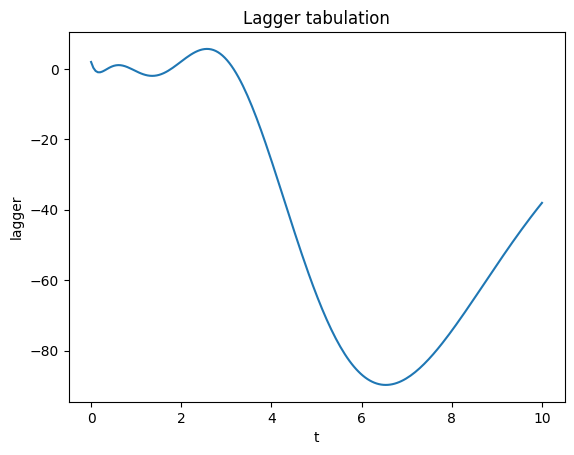

In [13]:
g = Graph(Lagger(2, 4), f, 10, 5)
g.tabulation_graph

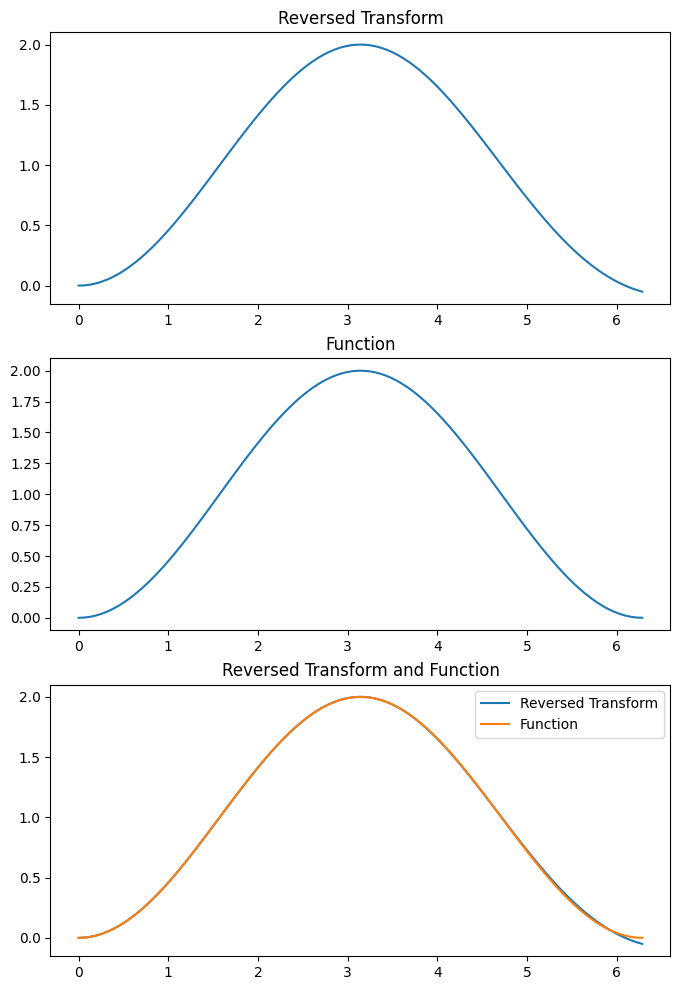

In [14]:
g.graph

In [15]:
class TestIntegral(unittest.TestCase):
    def test_init(self):
        integral = Integral(0, 10, 0.001)
        self.assertEqual(integral.a, 0)
        self.assertEqual(integral.b, 10)
        self.assertEqual(integral.e, 0.001)
        
    def test_a(self):
        integral = Integral(0, 10, 0.001)
        integral.a = 5
        self.assertEqual(integral.a, 5)
        
    def test_b(self):
        integral = Integral(0, 10, 0.001)
        integral.b = 15
        self.assertEqual(integral.b, 15)
        
    def test_e(self):
        integral = Integral(0, 10, 0.001)
        integral.e = 0.0001
        self.assertEqual(integral.e, 0.0001)
        
    def test_e_exception(self):
        with self.assertRaises(ValueError):
            integral = Integral(0, 10, -0.001)
            
    def test_b_exception(self):
        with self.assertRaises(ValueError):
            integral = Integral(5, 10, 0.001)
            integral.b = 4
            
    def test_rectangle_integral(self):
        integral = Integral(0, 10, 0.001)
        self.assertEqual(integral.rectangle_integral(lambda x: x**2), 333.334)
        self.assertEqual(integral.rectangle_integral(lambda x: x**3), 2500.001)
        self.assertEqual(integral.rectangle_integral(lambda x: np.sin(x)), 1.839)

In [16]:
class TestLagger(unittest.TestCase):
    def test_init(self):
        lagger = Lagger(2, 4)
        self.assertEqual(lagger.B, 2)
        self.assertEqual(lagger.O, 4)
        
    def test_B(self):
        lagger = Lagger(2, 4)
        lagger.B = 3
        self.assertEqual(lagger.B, 3)
        
    def test_O(self):
        lagger = Lagger(2, 4)
        lagger.O = 5
        self.assertEqual(lagger.O, 5)
        
    def test_B_exception(self):
        with self.assertRaises(ValueError):
            lagger = Lagger(-2, 4)
            
    def test_O_exception(self):
        with self.assertRaises(ValueError):
            lagger = Lagger(2, 1)
            
    def test_calulate_lagger(self):
        lagger = Lagger(2, 4)
        self.assertEqual(lagger.calulate_lagger(3, 5), 2.728331346558944)
        self.assertEqual(lagger.calulate_lagger(0, 0), 2)
        self.assertEqual(lagger.calulate_lagger(1, 1), -2.207276647028654)
        
    def test_tabulate_lagger(self):
        lagger = Lagger(2, 4)
        self.assertEqual(lagger.tabulate_lagger(10, 5).shape, (200, 3))
        self.assertEqual(lagger.tabulate_lagger(10, 5, 10).shape, (10, 3))
        
    def test_lagger_transformation_coefficients(self):
        lagger = Lagger(2, 4)
        self.assertEqual(lagger.lagger_transformation_coefficients(f, 10, 20).shape, (21, 2))
        self.assertEqual(lagger.lagger_transformation_coefficients(f, 10, 20)['f'][0], 0.0666)
        self.assertEqual(lagger.lagger_transformation_coefficients(f, 10, 20)['f'][20], 0.0)
        
    def test_lagger_inverse_transformation(self):
        lagger = Lagger(2, 4)
        self.assertEqual(lagger.lagger_inverse_transformation(lagger.lagger_transformation_coefficients(f, 10, 20)['f'], np.pi, 20), 1.999286356693321)
        self.assertEqual(lagger.lagger_inverse_transformation(lagger.lagger_transformation_coefficients(f, 10, 20)['f'], 0, 20), 0.0001999999999999638)

In [17]:
class TestExperiment(unittest.TestCase):
    def test_init(self):
        lagger = Lagger(2, 4)
        experiment = Experiment(lagger)
        self.assertEqual(experiment.lagger, lagger)
        
    def test_lagger_exception(self):
        with self.assertRaises(ValueError):
            experiment = Experiment(2)
    
    def test_experiment(self):
        lagger = Lagger(2, 4)
        exp = Experiment(lagger)
        df, ans = exp.experiment(100)
        self.assertEqual(df.shape, (21, 3))
        self.assertEqual(ans, 79.07907907907908)
        self.assertEqual(df['lagger'][0], 9.066137838279844e-35)
        self.assertEqual(df['lagger'][10], 1.8081683629428342e-16)
        self.assertEqual(df['lagger'][20], 0.0009699020960047245)

In [18]:
class TestGraph(unittest.TestCase):
    def test_init(self):
        laggerr = Lagger(2, 4)
        g = Graph(laggerr, f, 10, 5)
        self.assertEqual(g.lagger, laggerr)
        self.assertEqual(g.f, f)
        self.assertEqual(g.T, 10)
        self.assertEqual(g.N, 5)
        
    def test_lagger_exception(self):
        with self.assertRaises(ValueError):
            g = Graph("Lagger", f, 10, 5)
            
    def test_f(self):
        g = Graph(Lagger(2, 4), f, 10, 5)
        g.f = lambda x: x**2
        self.assertEqual(g.f(2), 4)
        
    def test_T(self):
        g = Graph(Lagger(2, 4), f, 10, 5)
        g.T = 20
        self.assertEqual(g.T, 20)
        
    def test_N(self):
        g = Graph(Lagger(2, 4), f, 10, 5)
        g.N = 10
        self.assertEqual(g.N, 10)
        
    def test_tabulation_graph(self):
        g = Graph(Lagger(2, 4), f, 10, 5)
        g.tabulation_graph
        
    def test_graph(self):
        g = Graph(Lagger(2, 4), f, 10, 5)
        g.graph

......

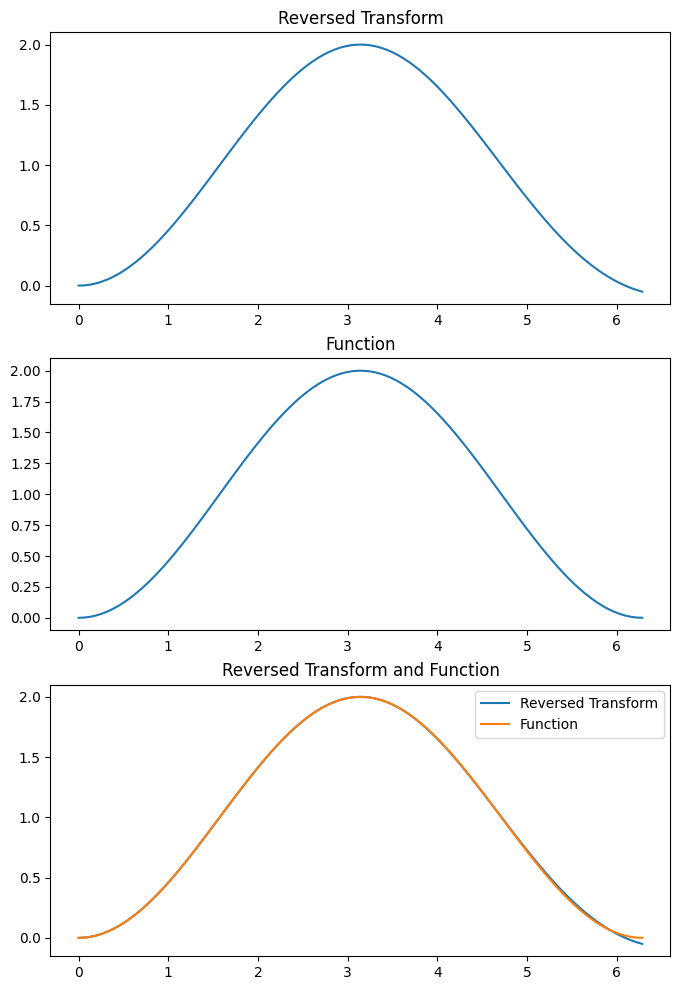

...

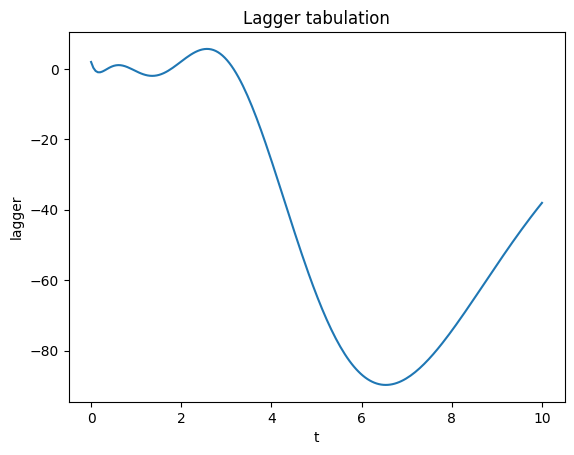

.................
----------------------------------------------------------------------
Ran 26 tests in 20.316s

OK


In [19]:
unittest.main(argv=[''], exit=False)